# MORL for water resource management

## Goals
Evaluate and compare novel MORL algorithms on a simulated water-reservoir environment (https://github.com/Farama-Foundation/MO-Gymnasium).

Algorithms:
- GPI-ls + TD3
- PCN
- ?

# TODO...

- Tune hyperparameters/environment parameters to get improved results using GPI-ls
- Decide between normalized actions or true actions
- Get a reference for comparing with GPI-ls results: PCN, original paper (MOFQI), [original experiment](https://github.com/sparisi/mips/tree/loopless/MDPs/Dam)
- Consider using [MOFQI](https://iwaponline.com/jh/article/15/2/258/3425/Tree-based-fitted-Q-iteration-for-multi-objective) instead of TD3 in combination with gpi-ls.


In [1]:
import mo_gymnasium as mo_gym
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from morl_baselines.multi_policy.gpi_pd.gpi_pd_continuous_action import GPIPDContinuousAction

"""
Helper function to plot pf
"""
# TODO: add no objectives as parameter (later)
def plot_pf(file):
    columns = ["objective_1", "objective_2"]
    df = pd.read_csv(file, usecols=columns)

    plt.plot(df.objective_1, df.objective_2, 'o')
    plt.xlabel('Cost due to excess water level wrt flooding threshold upstream')
    plt.ylabel('Deficit in water supply wrt demand')
    plt.show()

## GPI-ls with TD3
Try this without the dynamics model for a fair comparison with PCN (later).

Algo parameters:
- per = True
- policy_noise = 0.002
- noise_clip = 0.005
- rest is default

Opt for smaller policy noise due to normalized actions. Note: normalized actions are learned/returned by the policy and converted to true actions before being taken by the environment.

Noise is calculated by:
- Obtain action from policy net (given the state and a weight vector). The action predicted bythe
- Obtain an equal-sized vector filled with random gaussians (mean 0 variance 1) clamped within [-noise_clip;noise_clip] and multiply with noise
- action + random_noise and clamp within -1 and 1.
- Multiply with action_scale = (action_high - action_low) / 2 and add action_bias = (action_high + action_low) / 2

Environment parameters:
- normalized_action = True
- penalize = True
- time_limit = 365 

### Bug?
Algorithm returns nan as values for ccs when normalized_action=False

    C:\Users\liamm\anaconda3\lib\site-packages\mo_gymnasium\envs\water_reservoir\dam_env.py:261: RuntimeWarning: invalid value encountered in multiply penalty = -self.penalize * np.abs(bounded_action - action)
    
This is probably caused by the use of action_space.high in the action_scale and action_bias buffers of the policy net

=> TEMP Fix: when placing an upper bound on the action other than np.inf (dam_env.py, line 113), agent trains. Maybe agents selects np.inf as action sometimes?

In [ ]:
env = mo_gym.make('water-reservoir-v0', normalized_action=True, nO=2, penalize=True, time_limit=365)

GPIAgent = GPIPDContinuousAction(env=env, per=True, dyna=False, experiment_name='gpi-ls_2_obj_NormAction_lessPolicyNoise', policy_noise=0.002, noise_clip=0.005)

GPIAgent.train(365000, env, ref_point=np.array([0,0], dtype=np.float32), timesteps_per_iter=36500, eval_freq=3650) #random ref_point, hv is not used in the algorithm so this does not matter for training

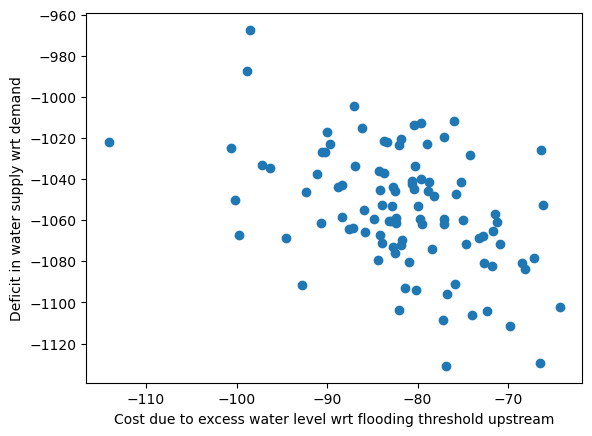

In [7]:
plot_pf('2obj_norm_lessPNoise.csv')

## Experiment with TD3 hyperparameters: Attempt #1

- net_arch = [500]

opt for single layer NN

In [2]:
env = mo_gym.make('water-reservoir-v0', normalized_action=True, nO=2, penalize=True, time_limit=365)

GPIAgent = GPIPDContinuousAction(env=env, per=True, dyna=False, experiment_name='gpi-ls_2_obj_NormAction_lessPolicyNoise_lessHiddenLayers', policy_noise=0.002, noise_clip=0.005, net_arch=[500])

GPIAgent.train(365000, env, ref_point=np.array([0,0], dtype=np.float32), timesteps_per_iter=36500, eval_freq=3650)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: liam-mertens02 (vub-ai). Use `wandb login --relogin` to force relogin


wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /tmp/gpi-ls_2_obj_NormAction_lessPolicyNoise_lessHiddenLayers


CCS: [] CCS size: 0
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [  -90.0921 -1047.2916] to CCS.
Adding value: [  -78.3286 -1002.1559] to CCS.
removed value [  -90.0921 -1047.2916]


wandb: WARNING Step cannot be set when using syncing with tensorboard. Please log your step values as a metric such as 'global_step'


W_corner: [array([1., 0.]), array([0., 1.])] W_corner size: 2
CCS: [array([  -78.3286, -1002.1559], dtype=float32)] CCS size: 1
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [  -76.1664 -1078.2339] to CCS.
Adding value: [  -88.0153 -1022.6454] to CCS.
Value [  -88.0153 -1022.6454] is dominated. Discarding.
Adding value: [  -77.4119 -1050.6255] to CCS.
Value [  -77.4119 -1050.6255] is dominated. Discarding.
W_corner: [array([1., 0.]), array([0.9724, 0.0276]), array([0., 1.])] W_corner size: 3
CCS: [array([  -78.3286, -1002.1559], dtype=float32), array([  -76.1664, -1078.2339], dtype=float32)] CCS size: 2
Next weight: [0.9724 0.0276]
Next weight vector: [0.9724 0.0276]
Adding value: [  -77.6765 -1018.5369] to CCS.
Value [  -77.6765 -1018.5369] is dominated. Discarding.
Adding value: [  -74.0643 -1056.9067] to CCS.
removed value [  -76.1664 -1078.2339]
Adding value: [  -90.004  -1005.2656] to CCS.
Value [  -90.004  -1005.2656] is dominated. Discarding.
Adding value: [  -8

eval/Mean Utility - GPI,▆▄▂█▅▃█▁▆▃
iteration,▁▂▃▃▄▅▆▆▇█
eval/Mean Utility - GPI,-569.59718
iteration,10


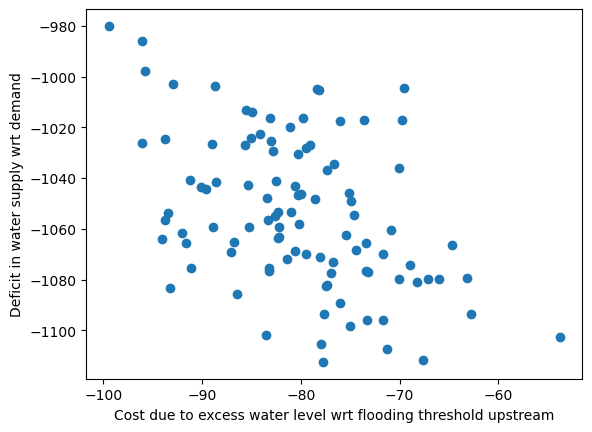

In [8]:
plot_pf("2obj_norm_lessPNoise_Hlayer500.csv")

When looking at the resulting solution set, the returns have improved slightly. We'll try to experiment more with the hidden layer configuration.

### Attempt #2

- net_arch = [200]

In [4]:
env = mo_gym.make('water-reservoir-v0', normalized_action=True, nO=2, penalize=True, time_limit=365)

GPIAgent = GPIPDContinuousAction(env=env, per=True, dyna=False, experiment_name='gpi-ls_2_obj_NormAction_lessPolicyNoise_lessHiddenLayers200', policy_noise=0.002, noise_clip=0.005, net_arch=[200])

GPIAgent.train(365000, env, ref_point=np.array([0,0], dtype=np.float32), timesteps_per_iter=36500, eval_freq=3650)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: liam-mertens02 (vub-ai). Use `wandb login --relogin` to force relogin


wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /tmp/gpi-ls_2_obj_NormAction_lessPolicyNoise_lessHiddenLayers200


CCS: [] CCS size: 0
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [  -79.212  -1043.5227] to CCS.
Adding value: [  -84.3196 -1079.4613] to CCS.
Value [  -84.3196 -1079.4613] is dominated. Discarding.


wandb: WARNING Step cannot be set when using syncing with tensorboard. Please log your step values as a metric such as 'global_step'


W_corner: [array([1., 0.]), array([0., 1.])] W_corner size: 2
CCS: [array([  -79.212 , -1043.5227], dtype=float32)] CCS size: 1
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [  -74.5399 -1055.2523] to CCS.
Adding value: [  -87.4739 -1046.2877] to CCS.
Value [  -87.4739 -1046.2877] is dominated. Discarding.
Adding value: [  -70.9345 -1052.2025] to CCS.
removed value [  -74.5399 -1055.2523]
W_corner: [array([1., 0.]), array([0.5119, 0.4881]), array([0., 1.])] W_corner size: 3
CCS: [array([  -79.212 , -1043.5227], dtype=float32), array([  -70.9345, -1052.2025])] CCS size: 2
Next weight: [0.5119 0.4881]
Next weight vector: [0.5119 0.4881]
Adding value: [ -87.7017 -983.5114] to CCS.
removed value [  -79.212  -1043.5227]
Adding value: [  -92.5898 -1037.0446] to CCS.
Value [  -92.5898 -1037.0446] is dominated. Discarding.
Adding value: [  -86.9717 -1039.5384] to CCS.
Value [  -86.9717 -1039.5384] is dominated. Discarding.
Adding value: [ -79.9389 -963.4485] to CCS.
removed va

eval/Mean Utility - GPI,▃▄█▄▃▁▂▂▆▇
iteration,▁▂▃▃▄▅▆▆▇█
eval/Mean Utility - GPI,-567.36678
iteration,10


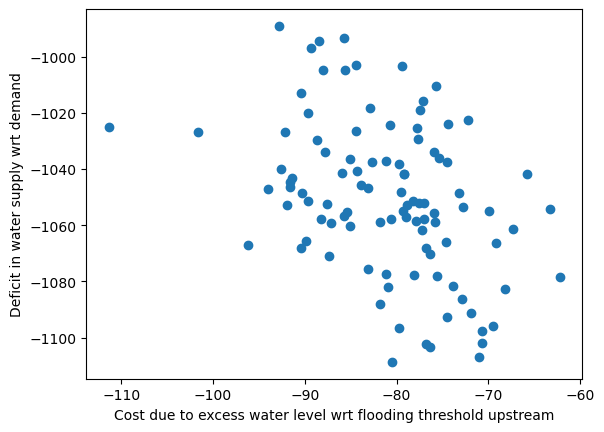

In [9]:
plot_pf("2obj_norm_lessPNoise_Hlayer200.csv")

The results are no better than in previous experiments, but we can clearly see that there is a case of [catastrophic forgetting](https://en.wikipedia.org/wiki/Catastrophic_interference): The mean utility increases up to a certain timestep and then decreases.

We can conclude that using only a single hidden layer suffices for now. Next, we can try to alter [batch size](https://openreview.net/pdf?id=B1Yy1BxCZ) or [buffer size](https://ai.stackexchange.com/questions/11640/how-large-should-the-replay-buffer-be).

## Attempt #3
First, try to increase the buffer size so that the network does not overfit on recent experiences.

- net_arch = [500]
- buffer_size = 3650


In [4]:
env = mo_gym.make('water-reservoir-v0', normalized_action=True, nO=2, penalize=True, time_limit=365)

GPIAgent = GPIPDContinuousAction(env=env, per=True, dyna=False, experiment_name='gpi-ls_2_obj_NormAction_lessPolicyNoise_lessHiddenLayers500_bufferSize3650', policy_noise=0.002, noise_clip=0.005, net_arch=[500], buffer_size=3650)

GPIAgent.train(365000, env, ref_point=np.array([0,0], dtype=np.float32), timesteps_per_iter=36500, eval_freq=3650)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: liam-mertens02 (vub-ai). Use `wandb login --relogin` to force relogin


wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /tmp/gpi-ls_2_obj_NormAction_lessPolicyNoise_lessHiddenLayers500_bufferSize3650


CCS: [] CCS size: 0
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [  -91.4887 -1043.3635] to CCS.
Adding value: [  -82.9375 -1083.8959] to CCS.


wandb: WARNING Step cannot be set when using syncing with tensorboard. Please log your step values as a metric such as 'global_step'


W_corner: [array([1., 0.]), array([0.8258, 0.1742]), array([0., 1.])] W_corner size: 3
CCS: [array([  -91.4887, -1043.3635], dtype=float32), array([  -82.9375, -1083.8959], dtype=float32)] CCS size: 2
Next weight: [0.8258 0.1742]
Next weight vector: [0.8258 0.1742]
Adding value: [  -83.1618 -1087.2312] to CCS.
Value [  -83.1618 -1087.2312] is dominated. Discarding.
Adding value: [  -85.7546 -1087.4425] to CCS.
Value [  -85.7546 -1087.4425] is dominated. Discarding.
Adding value: [  -84.1725 -1057.924 ] to CCS.
Value [  -84.1725 -1057.924 ] is dominated. Discarding.
Adding value: [  -78.6874 -1023.8228] to CCS.
removed value [  -82.9375 -1083.8959]
removed value [  -91.4887 -1043.3635]
Adding value: [  -72.5249 -1098.1948] to CCS.
W_corner: [array([1., 0.]), array([0.9235, 0.0765]), array([0., 1.])] W_corner size: 3
CCS: [array([  -78.6874, -1023.8228]), array([  -72.5249, -1098.1948])] CCS size: 2
Next weight: [0.9235 0.0765]
Next weight vector: [0.9235 0.0765]
Adding value: [  -70.766

eval/Mean Utility - GPI,▅▇▆▁▆█▄▆▆▇
iteration,▁▂▃▃▄▅▆▆▇█
eval/Mean Utility - GPI,-567.61581
iteration,10


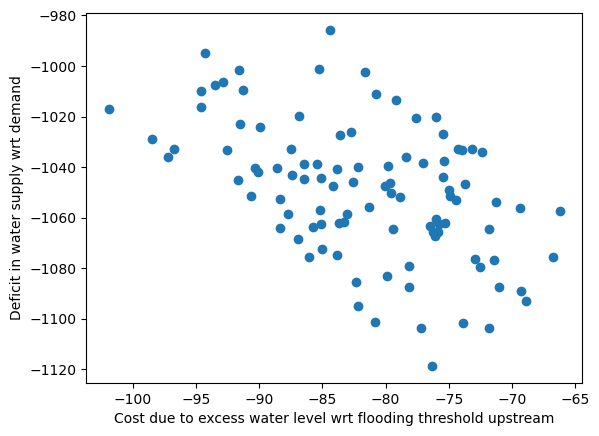

In [10]:
plot_pf('2obj_norm_lessPNoise_Hlayer200buffer3650.csv')

The resulting CCS is very similar to the previous.

## Comparison with original paper

In [this paper](https://iwaponline.com/jh/article/15/2/258/3425/Tree-based-fitted-Q-iteration-for-multi-objective) an experiment on the same simulated dam environment was conducted. Their results are a lot better, but the environment was only simulated for 100 timesteps/episode instead of the 365 used here.

We now conduct an experiment to test the randomness of the environment and see if this influences the mean utility. In order to test this, evaluate the policy for significantly more episodes (50) 

In order to reduce training time, set time_limit = 100

In [3]:
env = mo_gym.make('water-reservoir-v0', normalized_action=True, nO=2, penalize=True, time_limit=100)

GPIAgent = GPIPDContinuousAction(env=env, per=True, dyna=False, experiment_name='gpi-ls_2_obj_NormAction_lessPolicyNoise_lessHiddenLayers500_bufferSize3650', policy_noise=0.002, noise_clip=0.005, net_arch=[500])

GPIAgent.train(100000, env, ref_point=np.array([0,0], dtype=np.float32), timesteps_per_iter=10000, eval_freq=1000, num_eval_episodes_for_front=50)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: liam-mertens02 (vub-ai). Use `wandb login --relogin` to force relogin


wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /tmp/gpi-ls_2_obj_NormAction_lessPolicyNoise_lessHiddenLayers500_bufferSize3650


CCS: [] CCS size: 0
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [ -89.0323 -671.4115] to CCS.
Adding value: [ -55.1178 -676.9745] to CCS.


wandb: WARNING Step cannot be set when using syncing with tensorboard. Please log your step values as a metric such as 'global_step'


W_corner: [array([1., 0.]), array([0.1409, 0.8591]), array([0., 1.])] W_corner size: 3
CCS: [array([ -89.0323, -671.4115], dtype=float32), array([ -55.1178, -676.9745], dtype=float32)] CCS size: 2
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [ -54.2932 -685.0519] to CCS.
removed value [ -55.1178 -676.9745]
Adding value: [ -55.3127 -681.4085] to CCS.
Value [ -55.3127 -681.4085] is dominated. Discarding.
Adding value: [ -49.0894 -688.355 ] to CCS.
removed value [ -54.2932 -685.0519]
Adding value: [ -57.5461 -687.8972] to CCS.
Value [ -57.5461 -687.8972] is dominated. Discarding.
Adding value: [ -55.1078 -675.7437] to CCS.
W_corner: [array([0.6769, 0.3231]), array([1., 0.]), array([0., 1.]), array([0.1132, 0.8868])] W_corner size: 4
CCS: [array([ -89.0323, -671.4115], dtype=float32), array([ -49.0894, -688.355 ]), array([ -55.1078, -675.7437])] CCS size: 3
Next weight: [0.6769 0.3231]
Next weight vector: [0.6769 0.3231]
Adding value: [ -49.3499 -692.3153] to CCS.
Value [

eval/Mean Utility - GPI,▄▁▂▁▂▁▂▄▇█
iteration,▁▂▃▃▄▅▆▆▇█
eval/Mean Utility - GPI,-369.20566
iteration,10


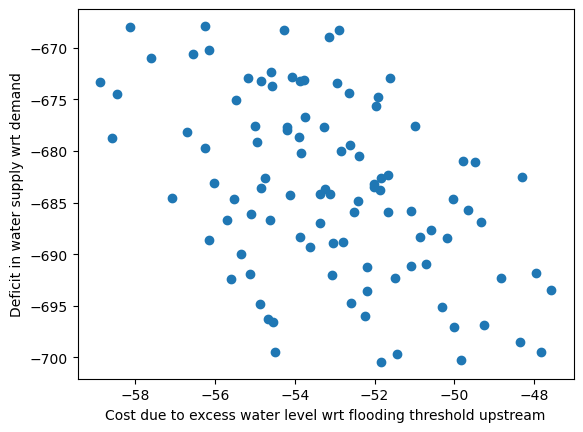

In [3]:
plot_pf('2obj_norm_lessPNoise_Hlayer500_eval50.csv')

When looking at the eval/mean utilty graph over time, the mean utility rises, but this is on a very small scale: an increase of +.200. 

## Try using non-normalized actions

manually place upper bound on the action space:
- Upper bound = 250.0

Also increase learning_starts to explore the environment a little more initially and boost learning.

In [2]:
env = mo_gym.make('water-reservoir-v0', normalized_action=False, nO=2, penalize=True, time_limit=100)

GPIAgent = GPIPDContinuousAction(env=env, per=True, dyna=False, experiment_name='gpi-ls_2_obj', learning_starts=1000)

GPIAgent.train(200000, env, ref_point=np.array([0,0], dtype=np.float32), timesteps_per_iter=10000, eval_freq=1000, num_eval_episodes_for_front=25)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: liam-mertens02 (vub-ai). Use `wandb login --relogin` to force relogin


wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /tmp/gpi-ls_2_obj


CCS: [] CCS size: 0
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [-214.8958 -657.5945] to CCS.
Adding value: [-169.8212 -651.1689] to CCS.
removed value [-214.8958 -657.5945]


wandb: WARNING Step cannot be set when using syncing with tensorboard. Please log your step values as a metric such as 'global_step'


W_corner: [array([1., 0.]), array([0., 1.])] W_corner size: 2
CCS: [array([-169.8212, -651.1689], dtype=float32)] CCS size: 1
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [-104.3247 -692.6697] to CCS.
Adding value: [-549.2895 -607.1148] to CCS.
removed value [-169.8212 -651.1689]
Adding value: [-118.5576 -696.2566] to CCS.
Value [-118.5576 -696.2566] is dominated. Discarding.
W_corner: [array([1., 0.]), array([0.1613, 0.8387]), array([0., 1.])] W_corner size: 3
CCS: [array([-104.3247, -692.6697], dtype=float32), array([-549.2895, -607.1148])] CCS size: 2
Next weight: [0.1613 0.8387]
Next weight vector: [0.1613 0.8387]
Adding value: [-211.0012 -692.3654] to CCS.
Value [-211.0012 -692.3654] is dominated. Discarding.
Adding value: [-1248.9389  -639.3292] to CCS.
Value [-1248.9389  -639.3292] is dominated. Discarding.
Adding value: [-215.07   -687.4335] to CCS.
Value [-215.07   -687.4335] is dominated. Discarding.
Adding value: [-1405.9442  -624.1142] to CCS.
Value [-1405

eval/Mean Utility - GPI,▃▅▁▅▄▇█▇▇█▇█▇▇▅█▇▇▇█
iteration,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
eval/Mean Utility - GPI,-373.48984
iteration,20


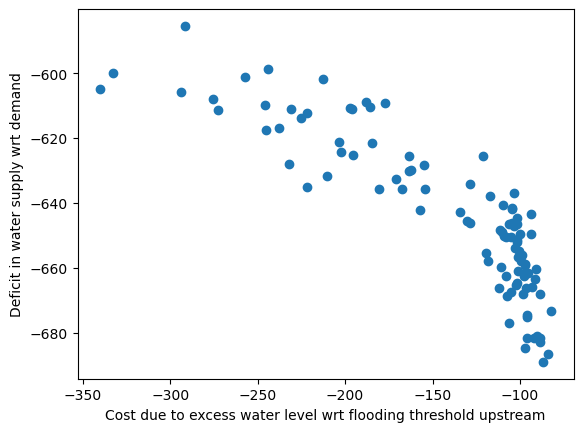

In [2]:
plot_pf('2obj_pen.csv')

Results are slightly worse than when using normalized actions. When compared to the experiments with normalised actions, it is clear that the returns of the water demand objective are higher than before.

## TODO:

Calculate the impact of noise parameters:
- noise value
- noise_clip value
- decide on noise decay or not

Increase learning_starts even more because the initial exploration seems valuable.

## Testing GPI-ls on other environemnts

Verify that we are in fact using the correct method for a continuous state MORL problem by training on the MO-hopper environment

In [4]:
env = mo_gym.make('mo-mountaincarcontinuous-v0')

GPIAgent = GPIPDContinuousAction(env=env, per=True, dyna=False, experiment_name='gpi-ls_cart')

GPIAgent.train(100000, env, ref_point=np.array([0,0], dtype=np.float32))

c:\Users\liamm\anaconda3\lib\site-packages\gymnasium\spaces\box.py:129: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: liam-mertens02 (vub-ai). Use `wandb login --relogin` to force relogin


wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /tmp/gpi-ls_cart


CCS: [] CCS size: 0
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [-9.9996e+01 -3.8620e-02] to CCS.
Adding value: [-99.9957 -58.0822] to CCS.


wandb: WARNING Step cannot be set when using syncing with tensorboard. Please log your step values as a metric such as 'global_step'


W_corner: [array([0., 1.]), array([1., 0.])] W_corner size: 2
CCS: [array([-9.9996e+01, -3.8620e-02], dtype=float32), array([-99.9957, -58.0822], dtype=float32)] CCS size: 2
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [-9.9996e+01 -5.1989e-02] to CCS.
removed value [-99.9957 -58.0822]
Adding value: [-99.9957 -62.562 ] to CCS.
removed value [-9.9996e+01 -5.1989e-02]
Adding value: [-9.9996e+01 -5.1786e-02] to CCS.
removed value [-99.9957 -62.562 ]
Adding value: [-99.9956 -63.2635] to CCS.
removed value [-9.9996e+01 -5.1786e-02]
W_corner: [array([1., 0.]), array([1.0000e+00, 1.5817e-06]), array([0., 1.])] W_corner size: 3
CCS: [array([-9.9996e+01, -3.8620e-02], dtype=float32), array([-99.9956, -63.2635])] CCS size: 2
Next weight: [1.0000e+00 1.5817e-06]
Next weight vector: [1.0000e+00 1.5817e-06]
Adding value: [-99.9957  -0.2137] to CCS.
Value [-99.9957  -0.2137] is dominated. Discarding.
Adding value: [-99.9956 -73.2671] to CCS.
removed value [-99.9956 -63.2635]
Adding

## Test on mujoco hopper

The results of the training on mountaincart were not great at all, in fact no learning occured...

In the [gpi paper](https://arxiv.org/abs/2301.07784), this environment was used to test the algorithm. The default algo hyperparameters correspond to those used in the paper.

In [2]:
env = mo_gym.make('mo-hopper-v4', cost_objective=False)

GPIAgent = GPIPDContinuousAction(env=env, per=True, dyna=False, experiment_name='gpi_hopper')

GPIAgent.train(100000, env, ref_point=np.array([0,0], dtype=np.float32))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: liam-mertens02 (vub-ai). Use `wandb login --relogin` to force relogin


wandb: WARNING Found log directory outside of given root_logdir, dropping given root_logdir for event file in /tmp/gpi_hopper


CCS: [] CCS size: 0
Next weight: [1. 0.]
Next weight vector: [1. 0.]
Adding value: [77.434  47.8285] to CCS.
Adding value: [119.1462   7.6028] to CCS.


wandb: WARNING Step cannot be set when using syncing with tensorboard. Please log your step values as a metric such as 'global_step'


W_corner: [array([0.4909, 0.5091]), array([1., 0.]), array([0., 1.])] W_corner size: 3
CCS: [array([77.434 , 47.8285], dtype=float32), array([119.1462,   7.6028], dtype=float32)] CCS size: 2
Next weight: [0.4909 0.5091]
Next weight vector: [0.4909 0.5091]
Adding value: [49.087  67.8163] to CCS.
removed value [77.434  47.8285]
Adding value: [152.2969 -15.3425] to CCS.
removed value [119.1462   7.6028]
Adding value: [58.3662 68.009 ] to CCS.
removed value [49.087  67.8163]
Adding value: [151.2888 -16.1646] to CCS.
Value [151.2888 -16.1646] is dominated. Discarding.
Adding value: [18.7578 43.6241] to CCS.
Value [18.7578 43.6241] is dominated. Discarding.
W_corner: [array([0.4702, 0.5298]), array([1., 0.]), array([0., 1.])] W_corner size: 3
CCS: [array([152.2969, -15.3425], dtype=float32), array([58.3662, 68.009 ])] CCS size: 2
Next weight: [0. 1.]
Next weight vector: [0. 1.]
Adding value: [165.3949 -10.0625] to CCS.
removed value [152.2969 -15.3425]
Adding value: [104.0224  38.6786] to CC

eval/Mean Utility - GPI,▂▁▄▃▅▆▆▆▇█
iteration,▁▂▃▃▄▅▆▆▇█
eval/Mean Utility - GPI,122.81824
iteration,10
